In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-005-000-010.root"

In [2]:
import time
import os
from mu2etools import *
from mu2etools import wideband

In [3]:
processor = wideband.DataProcessor(usexroot=True,
                                   fixtimes=False,
                                   treename='run', 
                                   filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'],
                                   runlist=[1635], userunlist=True, remove=False
                                  )
ar = processor.getData(DATASET)
hep.style.use('ATLAS')  # or ATLAS/LHCb2

Text(1, 0, 'PEs')

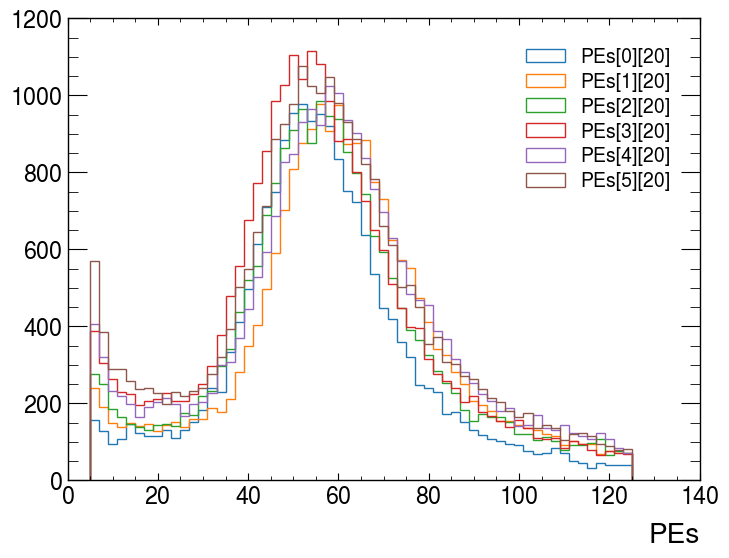

In [4]:
for feb in range(0,6):
    plt.hist(ar['PEs'][:,feb,20], histtype='step', bins=60, range=[5, 125], label='PEs[%d][20]'%feb);
plt.legend()
plt.xlabel('PEs')

In [5]:
feb_masks = []
#Fill the list of bool arrays for triggered modules
for feb in [0,1,2,5]:
    print("Processing FEB %d"%feb)
    feb_mask = ak.sum(ar['PEs'][:, feb, 8:24], axis=-1) > 10
    feb_masks.append(feb_mask)
    feb_mask = ak.sum(ar['PEs'][:, feb, 40:56], axis=-1) > 10
    feb_masks.append(feb_mask)
feb_trig_masks = list(feb_masks[i] for i in range(len(feb_masks))) # Trig layers starting from the top

nTrigHits = sum(ak.values_astype(mask, "int") for mask in feb_trig_masks)

#Get cleaned up array with hits in the triggered layers 
ar_trig = ar[nTrigHits>=7]

Processing FEB 0
Processing FEB 1
Processing FEB 2
Processing FEB 5


In [6]:
def getNHits(threshold = 10):
    feb_masks = []
    #Fill the list of bool arrays for test modules
    for feb in [3,4]:
        feb_mask = ak.sum(ar_trig['PEs'][:, feb, 0:32], axis=-1) > threshold
        feb_masks.append(feb_mask)
        feb_mask = ak.sum(ar_trig['PEs'][:, feb, 32:64], axis=-1) > threshold
        feb_masks.append(feb_mask)
    feb_test_masks = list(feb_masks[i] for i in range(len(feb_masks)))
    return feb_test_masks

In [7]:
feb_test_masks = []
nTestHits = []
thresholds = range(10, 150, 10)

for index, threshold in enumerate(thresholds):
    completion_percentage = (index+1) / len(thresholds) * 100
    print(f"{completion_percentage:.2f}% complete       \r", end="")
    feb_test_masks_ = getNHits(threshold)
    feb_test_masks.append(feb_test_masks_)
    nTestHits_ = sum(ak.values_astype(mask, "int") for mask in feb_test_masks_)
    nTestHits.append(nTestHits_)


In [8]:
df = pd.DataFrame(columns=['layer', 'threshold', 'inefficiency'])
for index, threshold in enumerate(thresholds):
    for layer in range(0,4):
        nSingleHits = ak.sum(feb_test_masks[index][layer])
        inefficiency = 1-nSingleHits/ak.count(ar_trig['eventNumber'])        
        new_row = {'layer': layer, 'threshold':threshold, 'inefficiency':inefficiency}
        df.loc[len(df)] = new_row

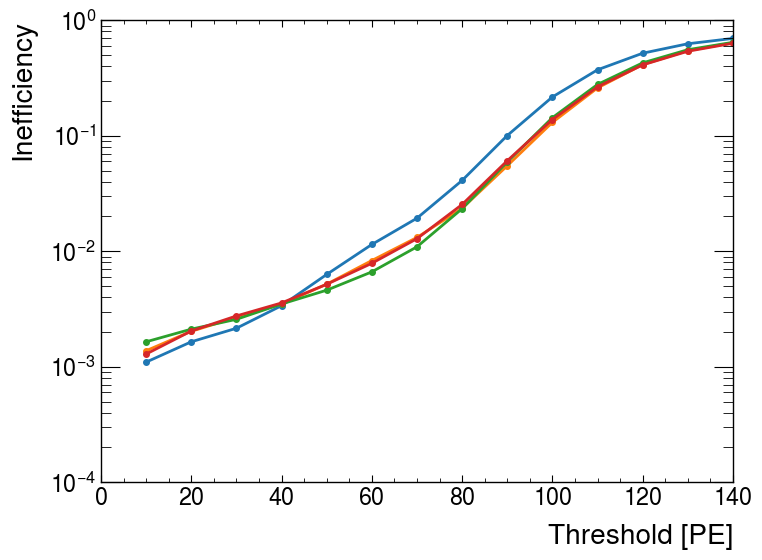

In [9]:
for layer in range(0,4):
    x=df.query('layer==%d'%layer)['threshold']
    y=df.query('layer==%d'%layer)['inefficiency']
    plt.plot(x, y, '.-');
    plt.yscale('log')
plt.ylabel('Inefficiency')
plt.xlabel('Threshold [PE]');

In [10]:
df = pd.DataFrame(columns=['nfold', 'threshold', 'inefficiency'])
nfolds = range(1,5)

for index, threshold in enumerate(thresholds):
    for nfold in nfolds:
        nPass = ak.count(ar_trig[(nTestHits[index]>=nfold)]['eventNumber'])
        nTrig = ak.count(ar_trig['eventNumber'])
        inefficiency = 1 - nPass/nTrig
        new_row = {'nfold': nfold, 'threshold':threshold, 'inefficiency':inefficiency}
        df.loc[len(df)] = new_row

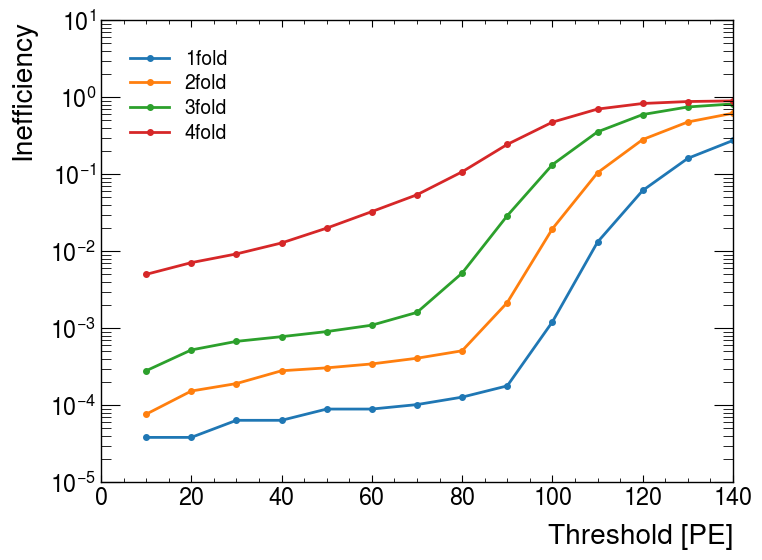

In [11]:
for nfold in nfolds:
    x=df.query('nfold==%d'%nfold)['threshold']
    y=df.query('nfold==%d'%nfold)['inefficiency']
    plt.plot(x, y, '.-', label='%dfold'%nfold);
    plt.yscale('log')
plt.ylabel('Inefficiency')
plt.xlabel('Threshold [PE]');
plt.legend();

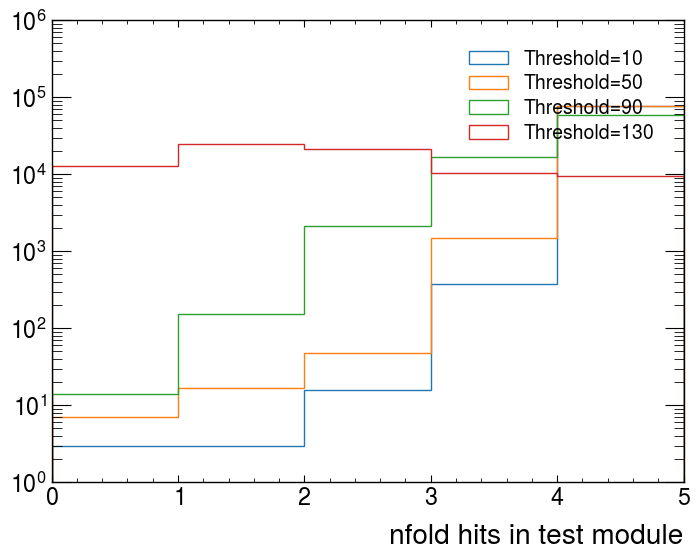

In [12]:
for index, threshold in enumerate(thresholds):
    if index % 4 == 0:
        plt.hist(nTestHits[index], histtype='step', bins=5, range=(0, 5), label='Threshold=%d'%threshold)
plt.yscale('log')
plt.legend();
plt.xlabel("nfold hits in test module");

In [13]:
#Failed events with only one hit in CRV at 10PE threshold
ar_trig[(nTestHits[0]==1)]

<Array [{spillNumber: 104, ...}, ..., {...}] type='3 * {spillNumber: int32,...'>